In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

'[' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"pytorch version: {torch.__version__}")

Using device: cuda
pytorch version: 2.4.0+cu124


In [5]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
#hide
Path.BASE_PATH = path

In [8]:
# Check the contents of the path
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [9]:
# Check the contents of the training set
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [17]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [25]:
# Check the number of 3s and 7s in the training set
print(len(threes), threes)
print(len(sevens), sevens)

6131 [Path('train/3/10.png'), Path('train/3/10000.png'), Path('train/3/10011.png'), Path('train/3/10031.png'), Path('train/3/10034.png'), Path('train/3/10042.png'), Path('train/3/10052.png'), Path('train/3/1007.png'), Path('train/3/10074.png'), Path('train/3/10091.png'), Path('train/3/10093.png'), Path('train/3/10097.png'), Path('train/3/10099.png'), Path('train/3/10116.png'), Path('train/3/10125.png'), Path('train/3/10137.png'), Path('train/3/10141.png'), Path('train/3/10144.png'), Path('train/3/10155.png'), Path('train/3/10161.png'), Path('train/3/10206.png'), Path('train/3/1021.png'), Path('train/3/10210.png'), Path('train/3/10214.png'), Path('train/3/10238.png'), Path('train/3/10260.png'), Path('train/3/10278.png'), Path('train/3/10282.png'), Path('train/3/10314.png'), Path('train/3/10322.png'), Path('train/3/10328.png'), Path('train/3/10329.png'), Path('train/3/10330.png'), Path('train/3/10349.png'), Path('train/3/1035.png'), Path('train/3/10360.png'), Path('train/3/10369.png'), P

In [31]:
# Ensure that the images are correct
im3_path = threes[0]
im3 = Image.open(im3_path)
im3

In [27]:
# Ensure that the images are correct
im7_path = sevens[0]
im7 = Image.open(im7_path)
im7

In [33]:
# Visualize the tensor
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0,0,0,0,0,0,0,0


## First attempt using Pixel Similarity

In [34]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

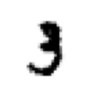

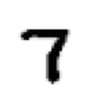

In [38]:
show_image(three_tensors[0]);
show_image(seven_tensors[0]);

In [40]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

print(stacked_threes.shape)
print(stacked_sevens.shape)

torch.Size([6131, 28, 28])
torch.Size([6265, 28, 28])


In [41]:
len(stacked_threes.shape)

3

In [42]:
stacked_threes.ndim

3

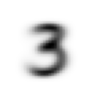

In [43]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

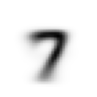

In [44]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

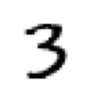

In [45]:
a_3 = stacked_threes[1]
show_image(a_3);

In [46]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [47]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [51]:
# Using L1 as the loss function
print(F.l1_loss(a_3.float(),mean7))

# Using MSE as the loss function
print(F.mse_loss(a_3,mean7).sqrt())

tensor(0.1586)
tensor(0.3021)


## Computing Metrics Using Broadcasting

In [61]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255


valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [62]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [67]:
print(valid_3_tens.shape)
print(mean3.shape)

torch.Size([1010, 28, 28])
torch.Size([28, 28])


In [68]:
# mean3 value is broadcasted to the shape of valid_3_tens
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [71]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [72]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [73]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [74]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [75]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

### An End-to-End SGD Example

In [83]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

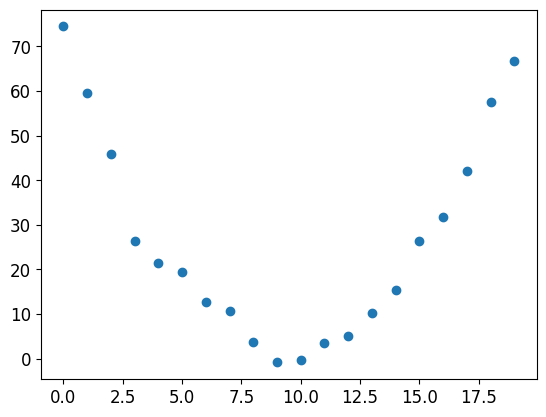

In [84]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [85]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [86]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [87]:
params = torch.randn(3).requires_grad_()

In [88]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [89]:
preds = f(time, params)

In [90]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

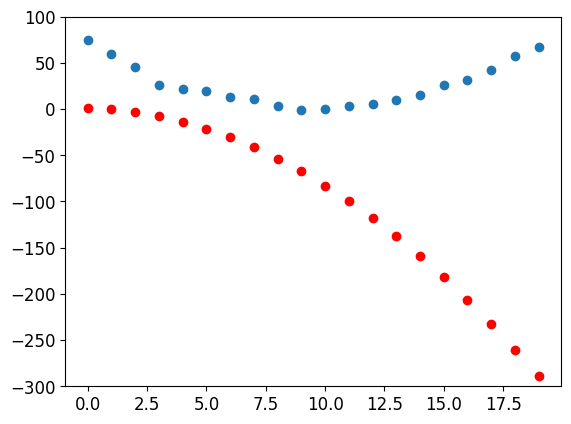

In [91]:
show_preds(preds)

#### Step 3: Calculate the loss

In [92]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [93]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [94]:
params.grad * 1e-5 # Assuming learning rate of 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [95]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights. 

In [96]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [97]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

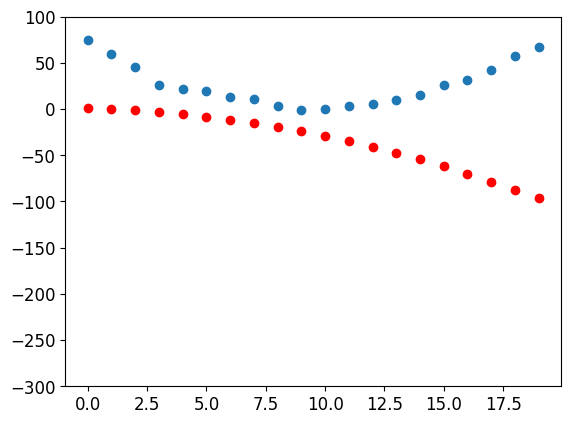

In [98]:
show_preds(preds) # To visually confirm that the predictions has improved

In [99]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [100]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [101]:
#hide
params = orig_params.detach().requires_grad_()

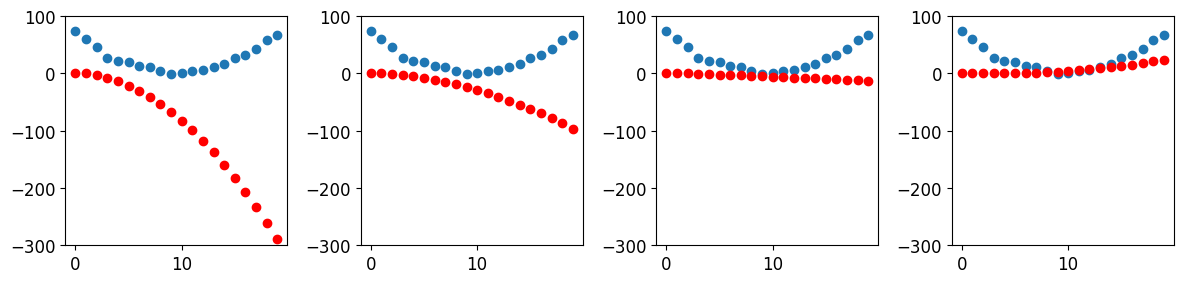

In [102]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

## The MNIST Loss Function

In [103]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [104]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # Label 1 for 3s and 0 for 7s, unsqueeze to make it a column vector
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [105]:
dset = list(zip(train_x,train_y))

x,y = dset[0] # Get the first sample for checking
x.shape,y

(torch.Size([784]), tensor([1]))

In [106]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [107]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [108]:
weights = init_params((28*28,1))

In [109]:
bias = init_params(1)

In [110]:
(train_x[0]*weights.T).sum() + bias # Running with 1 sample to check

tensor([20.2336], grad_fn=<AddBackward0>)

In [111]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [112]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [113]:
corrects.float().mean().item()

0.4912068545818329

In [114]:
with torch.no_grad(): weights[0] *= 1.0001

In [115]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

In [116]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [117]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [118]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [119]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [120]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [121]:
def sigmoid(x): return 1/(1+torch.exp(-x))

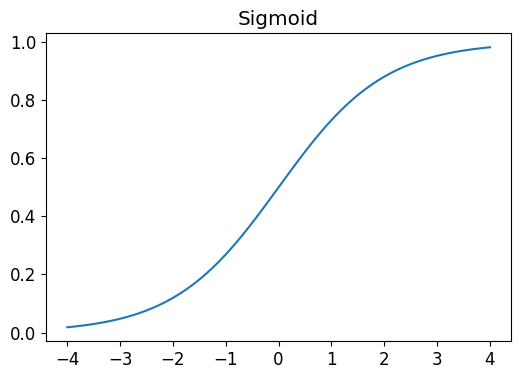

In [122]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [123]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Putting It All Together

In [147]:
weights = init_params((28*28,1))
bias = init_params(1)

In [148]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [149]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [150]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [151]:
preds = linear1(batch)
preds

tensor([[-0.6806],
        [-4.8113],
        [ 2.3936],
        [-2.4366]], grad_fn=<AddBackward0>)

In [152]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.6648, grad_fn=<MeanBackward0>)

In [153]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0143), tensor([-0.0954]))

In [154]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [155]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0285), tensor([-0.1909]))

In [156]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0428), tensor([-0.2863]))

In [157]:
weights.grad.zero_()
bias.grad.zero_();

In [158]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [159]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

In [160]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [161]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [162]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [163]:
validate_epoch(linear1)

0.3279

In [164]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4961

In [165]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print('Batch accuracy:', validate_epoch(linear1))

Batch accuracy: 0.502
Batch accuracy: 0.7059
Batch accuracy: 0.8305
Batch accuracy: 0.9042
Batch accuracy: 0.9291
Batch accuracy: 0.9433
Batch accuracy: 0.9496
Batch accuracy: 0.9531
Batch accuracy: 0.956
Batch accuracy: 0.9599
Batch accuracy: 0.9638
Batch accuracy: 0.9643
Batch accuracy: 0.9658
Batch accuracy: 0.9672
Batch accuracy: 0.9687
Batch accuracy: 0.9687
Batch accuracy: 0.9692
Batch accuracy: 0.9697
Batch accuracy: 0.9697
Batch accuracy: 0.9711


### Creating an Optimizer

In [179]:
linear_model = nn.Linear(28*28,1)

In [180]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [181]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [182]:
opt = BasicOptim(linear_model.parameters(), lr)

In [183]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [184]:
validate_epoch(linear_model)

0.4737

In [185]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print('Batch accuracy:', validate_epoch(model))

In [186]:
train_model(linear_model, 20)

Batch accuracy: 0.4932
Batch accuracy: 0.7798
Batch accuracy: 0.8506
Batch accuracy: 0.9146
Batch accuracy: 0.9355
Batch accuracy: 0.9473
Batch accuracy: 0.9555
Batch accuracy: 0.9629
Batch accuracy: 0.9658
Batch accuracy: 0.9663
Batch accuracy: 0.9697
Batch accuracy: 0.9721
Batch accuracy: 0.9736
Batch accuracy: 0.9751
Batch accuracy: 0.9761
Batch accuracy: 0.9761
Batch accuracy: 0.9775
Batch accuracy: 0.978
Batch accuracy: 0.978
Batch accuracy: 0.9785


In [187]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

Batch accuracy: 0.4932
Batch accuracy: 0.8677
Batch accuracy: 0.8281
Batch accuracy: 0.9092
Batch accuracy: 0.9331
Batch accuracy: 0.9453
Batch accuracy: 0.9546
Batch accuracy: 0.9619
Batch accuracy: 0.9653
Batch accuracy: 0.9673
Batch accuracy: 0.9687
Batch accuracy: 0.9712
Batch accuracy: 0.9731
Batch accuracy: 0.9746
Batch accuracy: 0.9756
Batch accuracy: 0.9765
Batch accuracy: 0.9775
Batch accuracy: 0.978
Batch accuracy: 0.9785
Batch accuracy: 0.9785


In [188]:
dls = DataLoaders(dl, valid_dl)

In [189]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [190]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637303,0.503536,0.495584,00:00
1,0.540681,0.170301,0.864573,00:00
2,0.197685,0.198077,0.817959,00:00
3,0.086273,0.111428,0.908734,00:00
4,0.045218,0.080187,0.932777,00:00
5,0.029223,0.063779,0.945535,00:00
6,0.022675,0.053640,0.954367,00:00
7,0.019786,0.046932,0.961236,00:00
8,0.018336,0.042249,0.965162,00:00
9,0.017473,0.038821,0.967615,00:00


## Adding a Nonlinearity

In [191]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [192]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

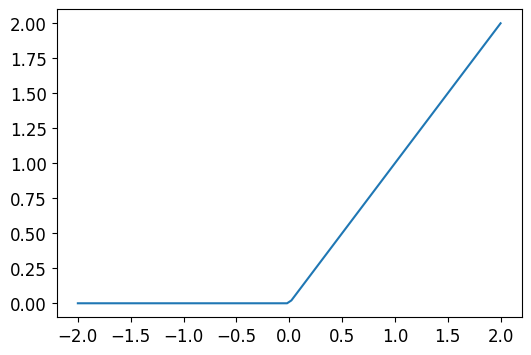

In [193]:
plot_function(F.relu)

In [194]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [195]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [196]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.300563,0.409787,0.505397,00:00
1,0.141857,0.225551,0.808145,00:00
2,0.079245,0.114195,0.915113,00:00
3,0.052497,0.077275,0.939647,00:00
4,0.040022,0.060451,0.956820,00:00
5,0.033615,0.050980,0.964181,00:00
6,0.029916,0.045000,0.965653,00:00
7,0.027501,0.040898,0.967125,00:00
8,0.025756,0.037902,0.968597,00:00
9,0.024401,0.035612,0.971050,00:00


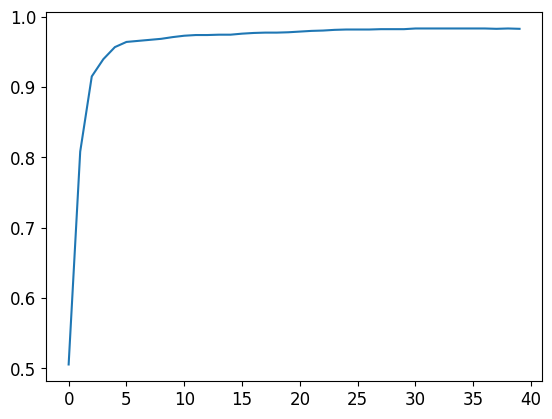

In [197]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [198]:
learn.recorder.values[-1][2]

0.982826292514801

### Using pretrained model

In [199]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.132167,0.043862,0.992640,00:11
